In [44]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
import tensorflow as tf


### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [7]:
base_path = '/home/cshentu/Documents/Faster_RCNN_for_Open_Images_Dataset_Keras'
images_boxable_fname = 'train-images-boxable.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [8]:
images_boxable = pd.read_csv(os.path.join(base_path, images_boxable_fname))
images_boxable.head()

,image_name,image_url
0,e39871fd9fd74f55.jpg,https://requestor-proxy.figure-eight.com/figur...
1,f18b91585c4d3f3e.jpg,https://requestor-proxy.figure-eight.com/figur...
2,ede6e66b2fb59aab.jpg,https://requestor-proxy.figure-eight.com/figur...
3,ed600d57fcee4f94.jpg,https://requestor-proxy.figure-eight.com/figur...
4,ff47e649b23f446d.jpg,https://requestor-proxy.figure-eight.com/figur...


In [9]:
annotations_bbox = pd.read_csv(os.path.join(base_path, annotations_bbox_fname))
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [10]:
class_descriptions = pd.read_csv(os.path.join(base_path, class_descriptions_fname))
class_descriptions.head()

,/m/011k07,Tortoise
0,/m/011q46kg,Container
1,/m/012074,Magpie
2,/m/0120dh,Sea turtle
3,/m/01226z,Football
4,/m/012n7d,Ambulance


### Show one image by using these three tables

In [11]:
print('length of the images_boxable: %d' %(len(images_boxable)) )
print('First image in images_boxable👇')
img_name = images_boxable['image_name'][0]
img_url = images_boxable['image_url'][0]
print('\t image_name: %s' % (img_name))
print('\t img_url: %s' % (img_url))
print('')
print('length of the annotations_bbox: %d' %(len(annotations_bbox)))
print('The number of bounding boxes are larger than number of images.')
print('')
print('length of the class_descriptions: %d' % (len(class_descriptions)-1))
img = io.imread(img_url)

length of the images_boxable: 1743042
First image in images_boxable👇
	 image_name: e39871fd9fd74f55.jpg
	 img_url: https://requestor-proxy.figure-eight.com/figure_eight_datasets/open-images/train/e39871fd9fd74f55.jpg

length of the annotations_bbox: 14610229
The number of bounding boxes are larger than number of images.

length of the class_descriptions: 599


In [12]:
class_needed = np.loadtxt("class-needed.csv", comments="#", delimiter=",",dtype = str, unpack=False)

In [13]:
class_needed

array(['Apple', 'Bagel', 'Banana', 'Bread', 'Broccoli', 'Burrito',
       'Carrot', 'Cheese', 'Coffee', 'Cookie', 'Croissant', 'Cucumber',
       'Doughnut', 'French fries', 'Fruit', 'Guacamole', 'Grape',
       'Hamburger', 'Hot dog', 'Juice', 'Lemon', 'Muffin', 'Orange',
       'Pancake', 'Pasta', 'Pear', 'Pizza', 'Potato', 'Salad',
       'Submarine sandwich', 'Strawberry', 'Tomato', 'Waffle'],
      dtype='<U18')

(1024, 768, 3)


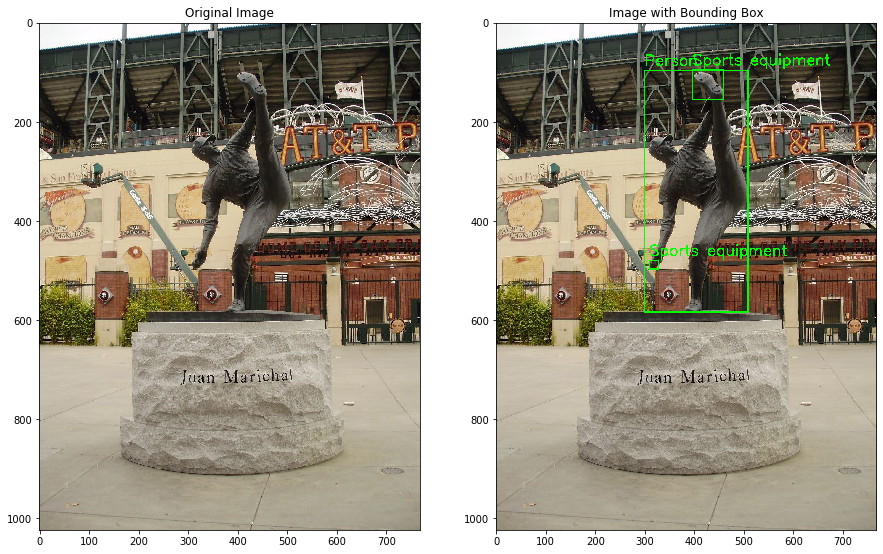

In [14]:
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
img_id = img_name[:16]
bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
img_bbox = img.copy()
for index, row in bboxs.iterrows():
    xmin = row['XMin']
    xmax = row['XMax']
    ymin = row['YMin']
    ymax = row['YMax']
    xmin = int(xmin*width)
    xmax = int(xmax*width)
    ymin = int(ymin*height)
    ymax = int(ymax*height)
    label_name = row['LabelName']
    class_series = class_descriptions[class_descriptions['/m/011k07']==label_name]
    class_name = class_series['Tortoise'].values[0]
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,class_name,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

In [15]:
# io.imsave(os.path.join(base_path,'Person')+'/1.jpg', img)

As we can see, by using these three tables, the image with bounding box could be drawn

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car.

The dataset from [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/download.html) is too large for me. So I just extract 1000 images for each class from the whole dataset.

In [176]:
pd

[    /m/011k07 Tortoise
 12  /m/014j1m    Apple,     /m/011k07 Tortoise
 64  /m/01fb_0    Bagel,     /m/011k07 Tortoise
 437  /m/09qck   Banana,     /m/011k07 Tortoise
 418  /m/09728    Bread,     /m/011k07  Tortoise
 554  /m/0hkxq  Broccoli,     /m/011k07 Tortoise
 76  /m/01j3zr  Burrito,      /m/011k07 Tortoise
 510  /m/0fj52s   Carrot,    /m/011k07 Tortoise
 98  /m/01nkt   Cheese,      /m/011k07 Tortoise
 187  /m/02vqfm   Coffee,     /m/011k07 Tortoise
 127  /m/021mn   Cookie,     /m/011k07   Tortoise
 23  /m/015wgc  Croissant,     /m/011k07  Tortoise
 24  /m/015x4r  Cucumber,     /m/011k07  Tortoise
 564  /m/0jy4k  Doughnut,     /m/011k07      Tortoise
 202  /m/02y6n  French fries,     /m/011k07 Tortoise
 201  /m/02xwb    Fruit,      /m/011k07   Tortoise
 163  /m/02g30s  Guacamole,     /m/011k07 Tortoise
 221  /m/0388q    Grape,     /m/011k07   Tortoise
 458  /m/0cdn1  Hamburger,     /m/011k07 Tortoise
 45  /m/01b9xk  Hot dog,       /m/011k07 Tortoise
 122  /m/01z1kdw    Juice,    

In [16]:
pd = []
for i in range (0,33):
    pd = pd + [class_descriptions[class_descriptions['Tortoise']==class_needed[i]]]

In [17]:
label_name = [0]*33
for i in range (0,33):
    label_name[i] = pd[i]['/m/011k07'].values[0]

In [18]:
print(pd[1])
print(label_name[1])


    /m/011k07 Tortoise
64  /m/01fb_0    Bagel
/m/01fb_0


**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [19]:
label_name[1]

'/m/01fb_0'

In [20]:
bbox = [0]*33
for i in range (0,33):
    bbox[i] = annotations_bbox[annotations_bbox['LabelName']==label_name[i]]

In [21]:
class_id = [0]*33
for i in range (0,33):
    print('There are %d %ss in the dataset' %(len(bbox[i]),class_needed[i]))
    class_id[i] = bbox[i]['ImageID']

There are 3898 Apples in the dataset
There are 640 Bagels in the dataset
There are 1612 Bananas in the dataset
There are 3846 Breads in the dataset
There are 1128 Broccolis in the dataset
There are 262 Burritos in the dataset
There are 1456 Carrots in the dataset
There are 1560 Cheeses in the dataset
There are 2384 Coffees in the dataset
There are 4158 Cookies in the dataset
There are 447 Croissants in the dataset
There are 1194 Cucumbers in the dataset
There are 930 Doughnuts in the dataset
There are 2114 French friess in the dataset
There are 26236 Fruits in the dataset
There are 224 Guacamoles in the dataset
There are 2787 Grapes in the dataset
There are 1486 Hamburgers in the dataset
There are 482 Hot dogs in the dataset
There are 2838 Juices in the dataset
There are 1756 Lemons in the dataset
There are 4608 Muffins in the dataset
There are 6195 Oranges in the dataset
There are 775 Pancakes in the dataset
There are 769 Pastas in the dataset
There are 923 Pears in the dataset
There 

In [22]:
for i in range (0,33):
    class_id[i] = np.unique(class_id[i])
    print('There are %d images which contain %ss' %(len(class_id[i]),class_needed[i]))


There are 1078 images which contain Apples
There are 262 images which contain Bagels
There are 723 images which contain Bananas
There are 1717 images which contain Breads
There are 475 images which contain Broccolis
There are 167 images which contain Burritos
There are 594 images which contain Carrots
There are 503 images which contain Cheeses
There are 1858 images which contain Coffees
There are 998 images which contain Cookies
There are 207 images which contain Croissants
There are 454 images which contain Cucumbers
There are 400 images which contain Doughnuts
There are 1121 images which contain French friess
There are 5283 images which contain Fruits
There are 181 images which contain Guacamoles
There are 767 images which contain Grapes
There are 1068 images which contain Hamburgers
There are 362 images which contain Hot dogs
There are 1746 images which contain Juices
There are 679 images which contain Lemons
There are 1364 images which contain Muffins
There are 900 images which con

We just randomly pick 800 images in here.

In [23]:
# Shuffle the ids and pick the first 800 ids
copy_id = class_id
random.seed(1)
for i in range (0,33):
    random.shuffle(copy_id[i])

n = 800
class_id = copy_id[:][:n]

In [24]:
# This might takes a while to search all these urls
img_url = [0]*33

for i in range (0,33):
    img_url[i] = [images_boxable[images_boxable['image_name']==name+'.jpg'] for name in class_id[i]]


KeyboardInterrupt: 

In [26]:
img_url = [0]*33
img_url[32] = [images_boxable[images_boxable['image_name']==name+'.jpg'] for name in class_id[32]]

In [27]:
for i in range (0,33):
    #pd[i] = pd[i].DataFrame()
    for j in range(len(img_url[i])):
        pd[i] = pd[i].append(img_url[i][j], ignore_index = True, sort=False)
    pd[i].to_csv(os.path.join(base_path, '%s_img_url.csv'%class_needed[i]))

TypeError: object of type 'int' has no len()

In [28]:
urls = []
for i in range (0,33):
    img_url[i] = [url['image_url'].values[0] for url in img_url[i]]
    urls = urls + [img_url[i]]


TypeError: 'int' object is not iterable

In [29]:
urls = [0]*33
img_url[32] = [url['image_url'].values[0] for url in img_url[32]]

urls[32] = img_url[32]

In [ ]:
urls[0][743]

In [33]:
saved_dirs = [os.path.join(base_path,'Apple'),os.path.join(base_path,'Bagel'),os.path.join(base_path,'Banana'),os.path.join(base_path,'Bread'),os.path.join(base_path,'Broccoli'),os.path.join(base_path,'Burrito'),os.path.join(base_path,'Carrot'),os.path.join(base_path,'Cheese'),os.path.join(base_path,'Coffee'),os.path.join(base_path,'Cookie'),os.path.join(base_path,'Croissant'),os.path.join(base_path,'Cucumber'),os.path.join(base_path,'Doughnut'),os.path.join(base_path,'French fries'),os.path.join(base_path,'Fruit'),os.path.join(base_path,'Guacamole'),os.path.join(base_path,'Grape'),os.path.join(base_path,'Hamburger'),os.path.join(base_path,'Hot dog'),os.path.join(base_path,'Juice'),os.path.join(base_path,'Lemon'),os.path.join(base_path,'Muffin'),os.path.join(base_path,'Orange'),os.path.join(base_path,'Pancake'),os.path.join(base_path,'Pasta'),os.path.join(base_path,'Pear'),os.path.join(base_path,'Pizza'),os.path.join(base_path,'Potato'),os.path.join(base_path,'Salad'),os.path.join(base_path,'Submarine sandwich'),os.path.join(base_path,'Strawberry'),os.path.join(base_path,'Tomato'),os.path.join(base_path,'Waffle')]

In [34]:
classes = class_needed

In [39]:
print(len(urls[32]))
print(len(urls[32]))
print(saved_dirs[32])

378
378
/home/cshentu/Documents/Faster_RCNN_for_Open_Images_Dataset_Keras/Waffle


### Download images

In [214]:
saved_dirs[5]

'/home/cshentu/Documents/Faster_RCNN_for_Open_Images_Dataset_Keras/Carrot'

In [215]:
# Download images
for i in range(len(classes)):
    # Create the directory
    os.mkdir(saved_dirs[i])
    saved_dir = saved_dirs[i]
    for url in urls[i]:
        # print(url)
        img = io.imread(url)
        saved_path = os.path.join(saved_dir, url[-20:])
        io.imsave(saved_path, img)

IndexError: list index out of range

In [37]:
os.mkdir(saved_dirs[32])
saved_dir = saved_dirs[32]
for url in urls[32]:
    # print(url)
    img = io.imread(url)
    saved_path = os.path.join(saved_dir, url[-20:])
    io.imsave(saved_path, img)

### Prepare dataset format for faster rcnn code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [40]:
# Save images to train and test directory
train_path = os.path.join(base_path, 'train')
os.mkdir(train_path)
test_path = os.path.join(base_path, 'test')
os.mkdir(test_path)

for i in range(len(classes)):
    
    all_imgs = os.listdir(os.path.join(base_path, classes[i]))
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.seed(1)
    random.shuffle(all_imgs)
    a = len(all_imgs)*0.8
    train_imgs = all_imgs[:int(a)]
    test_imgs = all_imgs[int(a):]
    
    # Copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(os.path.join(base_path, classes[i]), train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # Copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(os.path.join(base_path, classes[i]), test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)


In [41]:
print('number of training images: ', len(os.listdir(train_path))) # subtract one because there is one hidden file named '.DS_Store'
print('number of test images: ', len(os.listdir(test_path)))

number of training images:  23642
number of test images:  6244


The expected number of training images and validation images should be 3x800 -> 2400 and 3x200 -> 600.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [45]:
label_names = label_name

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [48]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                test_df = test_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [49]:
train_df.to_csv(os.path.join(base_path, 'train.csv'))
test_df.to_csv(os.path.join(base_path, 'test.csv'))

### Write train.csv to annotation.txt

In [50]:
# print(train_df.head())
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))

# For training
f= open(base_path + "/annotation.txt","w+")
for idx, row in train_df.iterrows():
#     sys.stdout.write(str(idx) + '\r')
#     sys.stdout.flush()
    img = cv2.imread((base_path + '/train/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    google_colab_file_path = '/home/cshentu/Documents/Faster_RCNN_for_Open_Images_Dataset_Keras/train'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
f.close()

In [51]:
print(test_df.head())
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# For test
f= open(base_path + "/test_annotation.txt","w+")
for idx, row in test_df.iterrows():
    sys.stdout.write(str(idx) + '\r')
    sys.stdout.flush()
    img = cv2.imread((base_path + '/test/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    google_colab_file_path = '/home/cshentu/Documents/Faster_RCNN_for_Open_Images_Dataset_Keras/test'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
f.close()

               FileName      XMin      XMax      YMin      YMax  ClassName
0  3425b257d89d2896.jpg  0.082813  0.469531  0.163542  0.833333    Burrito
1  3425b257d89d2896.jpg  0.481250  0.934375  0.168750  0.817708    Burrito
2  947ac737d856bd53.jpg  0.000000  0.435937  0.248437  0.998438  Hamburger
3  947ac737d856bd53.jpg  0.148438  0.998438  0.000000  0.914062  Hamburger
4  9ac224cdf9568888.jpg  0.742500  0.927500  0.649254  0.929105      Fruit
